In [ ]:
from utils.pkl_preprocessor import PickleBatchLoader
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


# Using XG-Boost


In [2]:
def train_xgboost_incrementally(batch_loader):
    """
    Function to train XGBoost incrementally on batches from a loader.
    This version corrects the incremental training logic.
    """
    # 1. Instantiate the classifier ONCE before the loop.
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
    )

    # This will hold the trained Booster object from the previous iteration.
    trained_booster = None

    print("--- Starting Incremental XGBoost Training ---")

    # 2. Loop through batches
    for i, (X_batch, y_batch) in enumerate(batch_loader.batch_generator()):
        print(f"  Training XGBoost on batch {i + 1}/{len(batch_loader)}...")

        # For the first batch, trained_booster is None.
        # For subsequent batches, it's the model from the last step.
        model.fit(X_batch, y_batch, xgb_model=trained_booster)

        # 3. Get the underlying booster to pass to the next iteration
        trained_booster = model.get_booster()

    # 4. Evaluation on the hold-out test set
    print("  Evaluating final XGBoost model...")
    X_test, y_test = batch_loader.get_test_set()
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    return accuracy * 100


# Using Random Forset


In [3]:
def train_random_forest_incrementally(batch_loader):
    """
    Function to train Random Forest using warm_start on batches.
    """
    # warm_start=True is key for incremental additions
    rf_model = RandomForestClassifier(n_estimators=5, random_state=42, warm_start=True)
    print("--- Starting Incremental Random Forest Training ---")

    # Training loop
    for i, (X_batch, y_batch) in enumerate(batch_loader.batch_generator()):
        print(f"  Training Random Forest on batch {i + 1}/{len(batch_loader)}...")
        rf_model.fit(X_batch, y_batch)
        # Increase the number of estimators for the next batch
        rf_model.n_estimators += 5

    # Evaluation on the hold-out test set
    print("  Evaluating final Random Forest model...")
    X_test, y_test = batch_loader.get_test_set()
    predictions = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy * 100


# Using Gradient Boosting


In [4]:
def train_gradient_boosting_incrementally(batch_loader):
    """
    Function to train Gradient Boosting using warm_start on batches.
    """
    # warm_start=True is key for incremental additions
    gb_model = GradientBoostingClassifier(
        n_estimators=5, learning_rate=0.1, max_depth=6, random_state=42, warm_start=True
    )
    print("--- Starting Incremental Gradient Boosting Training ---")

    # Training loop
    for i, (X_batch, y_batch) in enumerate(batch_loader.batch_generator()):
        print(f"  Training Gradient Boosting on batch {i + 1}/{len(batch_loader)}...")
        gb_model.fit(X_batch, y_batch)
        # Increase the number of estimators for the next batch
        gb_model.n_estimators += 5

    # Evaluation on the hold-out test set
    print("  Evaluating final Gradient Boosting model...")
    X_test, y_test = batch_loader.get_test_set()
    predictions = gb_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy * 100


In [5]:
BATCH_SIZE = 100096
for rounds in range(4, 6, 1):
    print("\n========================================================")
    print(f"Processing Round {rounds} from file")
    print("========================================================\n")
    rounds_list = []
    xgboost_accuracies = []
    # random_forest_accuracies = []
    # gradient_boosting_accuracies = []
    delta_list = []
    for delta in range(1, 129, 1):
        pickle_file = (
            f"dataset_pkl_round_{rounds}/SM4_{rounds}_round_delta-{delta}_combined.pkl"
        )
        print("\n========================================================")
        print(f"Processing Delta {delta}/128 from file: {pickle_file}")
        print("========================================================\n")
        try:
            batch_loader = PickleBatchLoader(pickle_file, batch_size=BATCH_SIZE)
            xgboost_accuracy = train_xgboost_incrementally(batch_loader)
            # random_forest_accuracy = train_random_forest_incrementally(batch_loader)
            # gradient_boosting_accuracy = train_gradient_boosting_incrementally(batch_loader)
            delta_list.append(delta)
            rounds_list.append(rounds)
            xgboost_accuracies.append(xgboost_accuracy)
            # random_forest_accuracies.append(random_forest_accuracy)
            # gradient_boosting_accuracies.append(gradient_boosting_accuracy)
            print(
                f"\nRound {rounds} Completed | "
                f"Final XGBoost Accuracy: {xgboost_accuracy:.4f}%\n"
                # f"Final Random Forest Accuracy: {random_forest_accuracy:.4f}%\n"
                # f"Final Gradient Boosting Accuracy: {gradient_boosting_accuracy:.4f}%\n"
            )
        except FileNotFoundError:
            print(f"File not found: {pickle_file}. Skipping round {rounds}.")
            continue
        except Exception as e:
            print(f"An error occurred during round {rounds}: {e}")
            continue
    results_df = pd.DataFrame(
        {
            "Deltas": delta_list,
            "XGBoost_Accuracy": xgboost_accuracies,
            # "RandomForest_Accuracy": random_forest_accuracies,
            # "GradientBoosting_Accuracy": gradient_boosting_accuracies,
        }
    )
    results_df.set_index("Deltas", inplace=True)
    print("\nFinal Results DataFrame:")
    print(results_df)
    results_df.to_pickle(f"model_accuracy_results_incremental_round_{rounds}.pkl")
    results_df.to_csv(f"model_accuracy_results_incremental_round_{rounds}.csv")
    print(
        f"\nDataFrame saved as 'model_accuracy_results_incremental_round_{rounds}.pkl' and .csv"
    )



Processing Round 4 from file


Processing Delta 1/128 from file: dataset_pkl_round_4/SM4_4_round_delta-1_combined.pkl

Loading data from dataset_pkl_round_4/SM4_4_round_delta-1_combined.pkl...
Preprocessing hold-out test set...
Loader initialized. Ready to generate batches.
--- Starting Incremental XGBoost Training ---
  Training XGBoost on batch 1/2...
  Training XGBoost on batch 2/2...
  Evaluating final XGBoost model...

Round 4 Completed | Final XGBoost Accuracy: 76.4330%


Processing Delta 2/128 from file: dataset_pkl_round_4/SM4_4_round_delta-2_combined.pkl

Loading data from dataset_pkl_round_4/SM4_4_round_delta-2_combined.pkl...
Preprocessing hold-out test set...
Loader initialized. Ready to generate batches.
--- Starting Incremental XGBoost Training ---
  Training XGBoost on batch 1/2...
  Training XGBoost on batch 2/2...
  Evaluating final XGBoost model...

Round 4 Completed | Final XGBoost Accuracy: 73.6107%


Processing Delta 3/128 from file: dataset_pkl_round_4/SM4_4_roun

# Code to Plot Graphs


In [6]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
round = 5

In [8]:
results_df = pd.read_pickle(f"model_accuracy_results_incremental_round_{round}.pkl")

In [9]:
results_df

,XGBoost_Accuracy
Deltas,
1,48.650066
2,48.662554
3,49.227004
4,48.425285
5,49.012213
...,...
124,67.933765
125,67.636554
126,77.599341


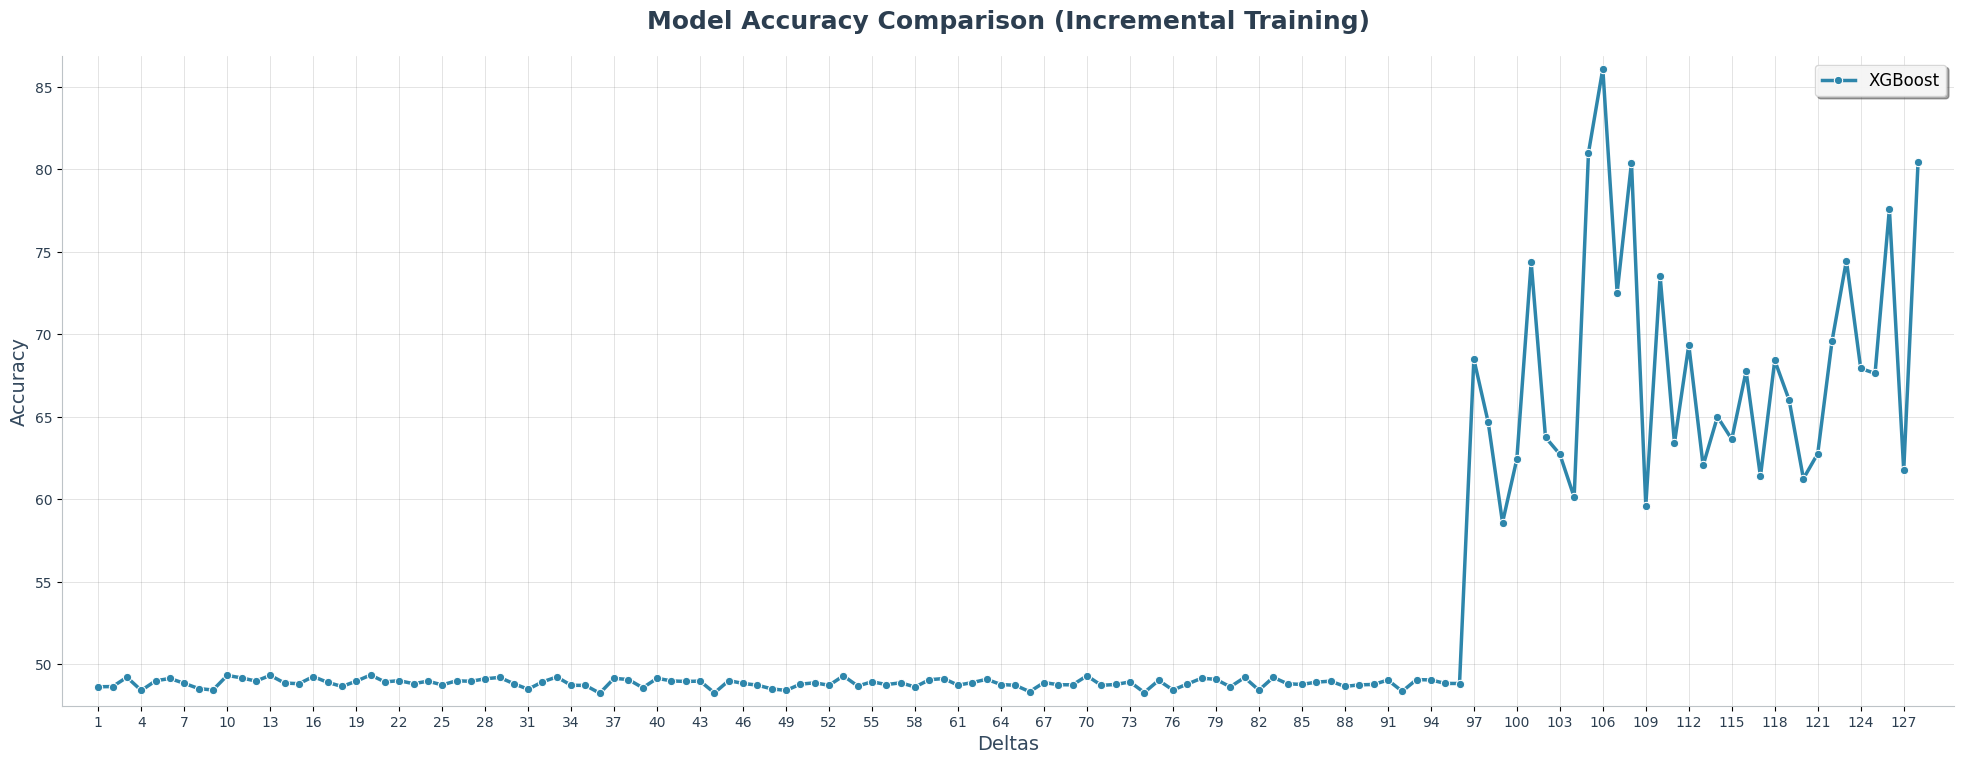

Enhanced plot saved as 'model_accuracy_comparison_incremental_round_5.png'


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for clean, aesthetic look
plt.style.use("default")  # Reset to default style
sns.set_palette("husl")  # Use a more aesthetic color palette

plt.figure(figsize=(20, 8), facecolor="white")
plot_df = results_df.reset_index()

# Create the plot with enhanced aesthetics
ax = plt.gca()
ax.set_facecolor("white")  # Ensure plot background is white

# Plot XGBoost with enhanced styling
sns.lineplot(
    data=results_df,
    x="Deltas",
    y="XGBoost_Accuracy",
    marker="o",
    label="XGBoost",
    linewidth=2.5,
    markersize=6,
    color="#2E86AB",  # Professional blue color
)

# Uncomment these for other models with aesthetic colors
# sns.lineplot(
#     data=plot_df,
#     x="Deltas",
#     y="RandomForest_Accuracy",
#     marker="s",
#     label="Random Forest",
#     linewidth=2.5,
#     markersize=6,
#     color='#A23B72'  # Professional magenta
# )
# sns.lineplot(
#     data=plot_df,
#     x="Deltas",
#     y="GradientBoosting_Accuracy",
#     marker="^",
#     label="Gradient Boosting",
#     linewidth=2.5,
#     markersize=6,
#     color='#F18F01'  # Professional orange
# )

# Enhanced title and labels
plt.title(
    "Model Accuracy Comparison (Incremental Training)",
    fontsize=18,
    fontweight="bold",
    color="#2c3e50",  # Dark blue-gray color
    pad=20,
)
plt.xlabel("Deltas", fontsize=14, fontweight="medium", color="#34495e")
plt.ylabel("Accuracy", fontsize=14, fontweight="medium", color="#34495e")

# Enhanced legend
plt.legend(
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    facecolor="white",
    edgecolor="lightgray",
    framealpha=0.9,
)

# Improved grid
plt.grid(True, alpha=0.3, linestyle="-", linewidth=0.5, color="gray")

# Enhanced tick styling
plt.xticks(range(1, 129, 3), fontsize=10, color="#2c3e50")
plt.yticks(fontsize=10, color="#2c3e50")

# Remove top and right spines for cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color("#bdc3c7")
ax.spines["bottom"].set_color("#bdc3c7")

# Set white background for the entire figure
plt.gcf().patch.set_facecolor("white")

# Reduce whitespace around the plot
plt.margins(x=0.02, y=0.02)
plt.tight_layout(pad=2.0)

# Save with white background
plt.savefig(
    f"model_accuracy_comparison_incremental_round_{round}.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",  # Ensure saved image has white background
    edgecolor="none",
)
plt.show()
print(
    f"Enhanced plot saved as 'model_accuracy_comparison_incremental_round_{round}.png'"
)


In [11]:
df_sorted = results_df.sort_values(by=["XGBoost_Accuracy"], ascending=[False])
df_sorted.head(10)


,XGBoost_Accuracy
Deltas,
106,86.088564
105,81.006019
128,80.416594
108,80.399111
126,77.599341
123,74.472389
101,74.374984
110,73.525812
107,72.526786
